In [ ]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
from itertools import combinations

# Ensure project root is on the import path
sys.path.insert(0, os.path.abspath('.'))

# Suppress warnings
warnings.filterwarnings("ignore")

# Imports
from Helper.evaluation_helpers import get_predictions
from dieboldmariano import dm_test
#from Helper.DM_Test import dm_test

from Training.Helper.PyTorchModular import HORIZONS

# Setup project paths
PROJECT_ROOT = Path().resolve().parents[0]
PRED_BASE = PROJECT_ROOT / 'Predictions'
SAVE_DIR = PROJECT_ROOT / 'Evaluation' / 'dm_test_results'
SAVE_DIR.mkdir(parents=True, exist_ok=True)

print("Running Diebold-Mariano tests on model predictions:")


for h in [1,3,6,12]:
    preds_dir = PRED_BASE / f"Horizon{h}"
    print(f"\nLooking in: {preds_dir} — Exists? {preds_dir.exists()}")

    if not preds_dir.exists():
        print(f"Horizon {h}: prediction folder not found — skipping.")
        continue

    preds_df = get_predictions(preds_dir)

    # Separate ground truth and predictions
    ground_truth = preds_df['ground_truth']
    models = preds_df.columns.drop('ground_truth')
    #print(ground_truth)
    print(f"Horizon {h} — {len(models)} models: {models}")

    if len(models) < 2:
        print(f"Horizon {h}: not enough models to compare — skipping.")
        continue

    results = []
    # Run DM test for each unique pair to prevent duplicate
    for model1 in models:
        if model1 == "Naive":
            continue
        
        n = int(h ** (1/3) + 1)
        dm_stat, p_val = dm_test(ground_truth,preds_df[model1],preds_df["Naive"],one_sided=True,h=n,variance_estimator="bartlett",harvey_correction=True)

        #dm_stat, p_val = dm_test(ground_truth, preds_df[model1], preds_df["Naive"], h=n, crit="MAPE")
        #print(model1,dm_stat)
        if p_val < 0.05:
            better_model = "Naive" if dm_stat > 0 else model1 
        else:
            better_model = "No significant difference"
        
        absolute_errors = np.abs(ground_truth - preds_df[model1])
        mae = np.mean(absolute_errors)
        results.append((model1, "Naive", dm_stat, p_val, better_model,mae))
        
    if not results:
        print(f"No valid DM tests for Horizon {h}.")
        continue

    # Create results DataFrame
    results_df = pd.DataFrame(results, columns=["Model_1", "Model_2", "DM_statistic", "p_value", "Better_Model","MAE"])
    results_df = results_df.sort_values(by="p_value").reset_index(drop=True)
    results_df.index += 1  # Start rank from 1
    results_df.insert(0, "Rank", results_df.index)

    # Save full ranked results
    save_path = SAVE_DIR / f"Horizon{h}_DM_results.csv"
    results_df.to_csv(save_path, index=False)
    print(f"Saved DM test ranked results: {save_path}")

    # Count how many times each model wins
    better_counts = results_df['Better_Model'].value_counts().reset_index()
    better_counts.columns = ['Model', 'Wins']
    better_counts = better_counts.sort_values(by="Wins", ascending=False).reset_index(drop=True)
    better_counts.index += 1  # Start rank from 1
    better_counts.insert(0, "Rank", better_counts.index)

    # Save better model rankings
    better_save_path = SAVE_DIR / f"Horizon{h}_Better_Model_Ranking.csv"
    better_counts.to_csv(better_save_path, index=False)
    print(f"Saved better model ranking: {better_save_path}")


Running Diebold-Mariano tests on model predictions:

Looking in: C:\Users\James\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon1 — Exists? True
observation_date
01/2024    122.115
02/2024    122.494
03/2024    122.912
04/2024    123.234
05/2024    123.224
06/2024    123.369
07/2024    123.575
08/2024    123.727
09/2024    123.939
10/2024    124.235
11/2024    124.387
12/2024    124.705
Name: ground_truth, dtype: float64
Horizon 1 — 20 models: Index(['ARDL', 'ARIMA1990', 'ARIMAX1990', 'GRU1990', 'LSTM', 'MARS', 'MLR',
       'Naive', 'NBEATSx', 'NHITS', 'RFX', 'RNN1990', 'SARIMA1990',
       'SARIMAX1990', 'TCN', 'TFT', 'Tide', 'VARccf', 'VARcointegration',
       'XGB1990'],
      dtype='object')
Saved DM test ranked results: C:\Users\James\COMP5530M-Group-Project-Inflation-Forecasting\Evaluation\dm_test_results\Horizon1_DM_results.csv
Saved better model ranking: C:\Users\James\COMP5530M-Group-Project-Inflation-Forecasting\Evaluation\dm_test_results\Horizon1_Better_Mo

2025-05-04 10:34:05,402 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,404 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,406 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,407 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Best model for horizion: 1 is NHITS


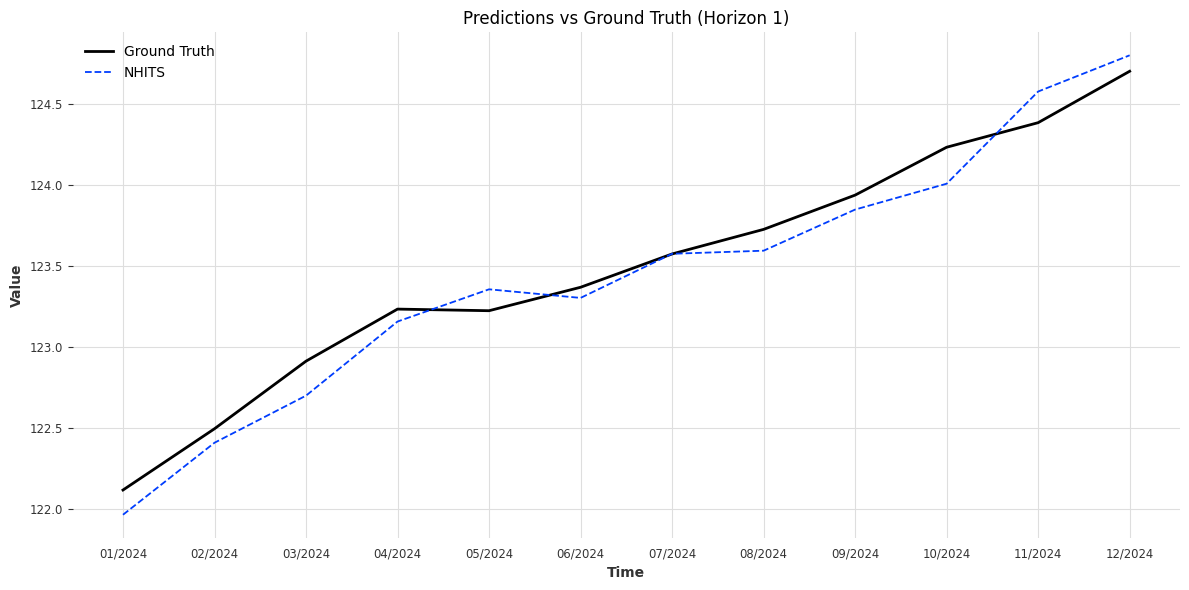

2025-05-04 10:34:05,546 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,547 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,549 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,550 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Best model for horizion: 3 is NHITS


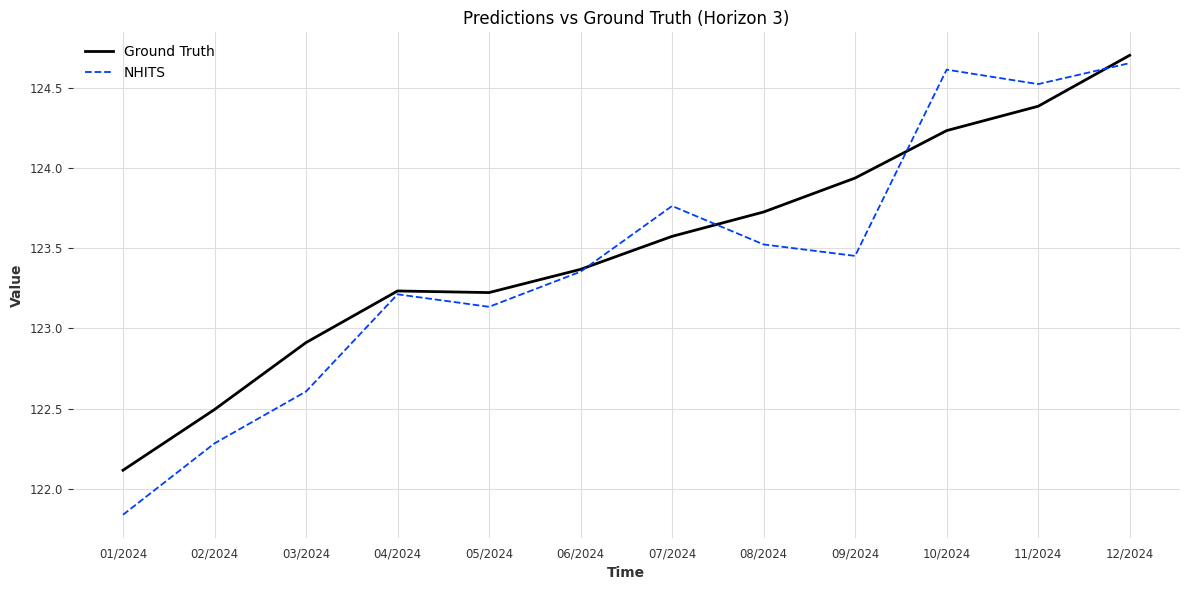

2025-05-04 10:34:05,684 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,686 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,687 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,688 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Best model for horizion: 6 is NHITS


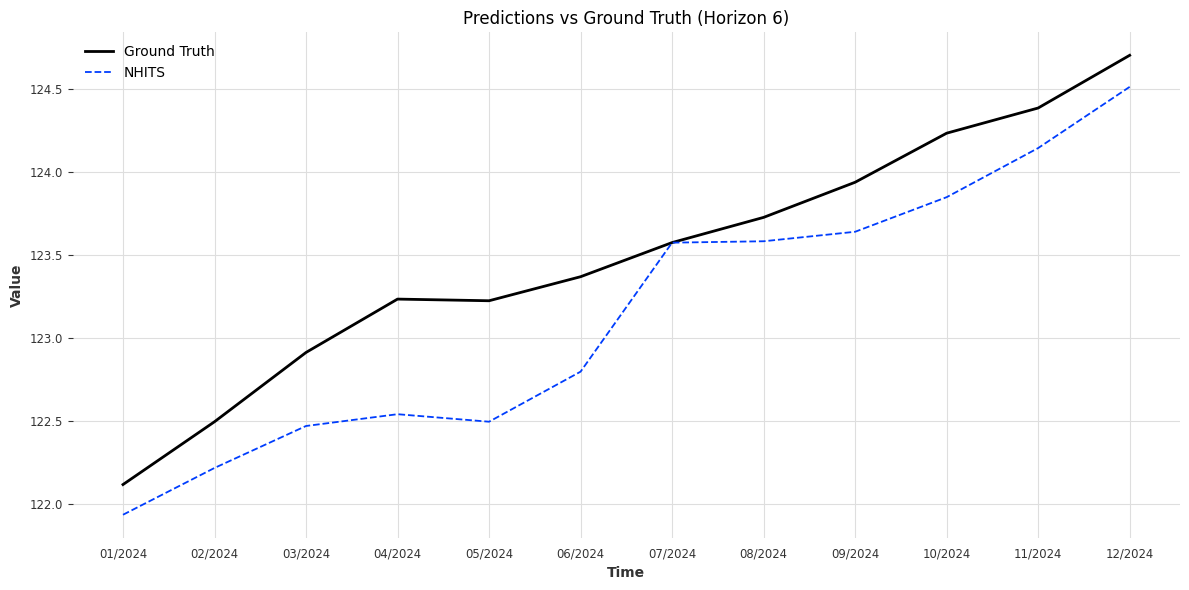

2025-05-04 10:34:05,819 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,821 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,822 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,823 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-04 10:34:05,824 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Best model for horizion: 12 is NHITS
Runners up are: ['VARcointegration', 'VARccf']


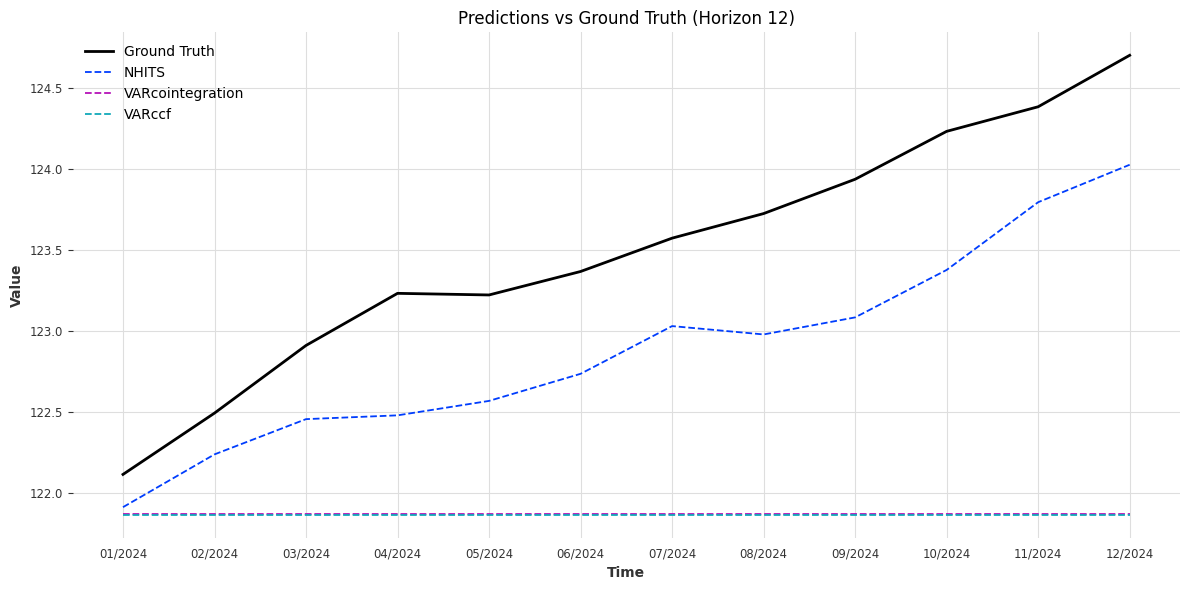

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Setup
PROJECT_ROOT = Path().resolve().parents[0]
SAVE_DIR = PROJECT_ROOT / 'Evaluation' / 'dm_test_results'
HORIZONS = [1, 3, 6, 12]


# Main loop
for h in HORIZONS:
    preds_dir = PRED_BASE / f"Horizon{h}"
    results_path = SAVE_DIR / f"Horizon{h}_DM_results.csv"
    wins_path = SAVE_DIR / f"Horizon{h}_Better_Model_Ranking.csv"
    
    preds_df = get_predictions(preds_dir)
    ground_truth = preds_df['ground_truth']

    if not results_path.exists() or not wins_path.exists():
        print(f"Horizon{h}: missing results — skipping.")
        continue

    # Load CSVs
    results_df = pd.read_csv(results_path)
    wins_df = pd.read_csv(wins_path)
    plt.figure(figsize=(12, 6))
    plt.plot(ground_truth.index, ground_truth.values, label='Ground Truth', linewidth=2)
   
    filtered = results_df[results_df["Better_Model"] != "No significant difference"].reset_index(drop=True)
    #print(filtered)
    
    if len(filtered) == 1:
        model = filtered.loc[0,"Better_Model"]
        print(f"Best model for horizion: {h} is {model}")
        plt.plot(preds_df.index, preds_df[model], label=model, linestyle='--')
    else:
        sortedMAE = filtered.sort_values(by="MAE").reset_index(drop=True)
        model = sortedMAE.loc[0,"Better_Model"]
        print(f"Best model for horizion: {h} is {model}")
        models = sortedMAE.loc[1:,"Better_Model"].to_list()
        print(f"Runners up are: {models}")
        for model in sortedMAE["Better_Model"]:
            plt.plot(preds_df.index, preds_df[model], label=model, linestyle='--')
        
    plt.title(f"Predictions vs Ground Truth (Horizon {h})")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
